In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import netCDF4 as nc
from scipy.ndimage import binary_dilation

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, smooth, robust_smooth, fit_psi_params, tangential_velocity, psi_params


#### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = np.squeeze(ssh_dataset['uo'][:].data), np.squeeze(ssh_dataset['vo'][:].data) 
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


#### Drifter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/ESP_Paper_Data/drifter_data_CCE_2023_6h.nc'

drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data, drifter_dataset['vn'][:].data
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_drifters['x'] = (df_drifters.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_drifters['y'] = (df_drifters.Lat - phi_mean) * 111000

df_drifters.head()


,ID,Lon,Lat,u,v,Time,x,y
0,300534062034380,153.975,-37.651,0.39605,0.45606,2023-10-19 12:00:00,-28466.208360,27639.0
1,300534062034380,154.095,-37.579,0.47131,0.32648,2023-10-19 18:00:00,-17955.608350,35631.0
2,300534062034380,154.206,-37.523,0.47029,0.15047,2023-10-20 00:00:00,-8233.303341,41847.0
3,300534062034380,154.325,-37.520,0.49572,-0.06028,2023-10-20 06:00:00,2189.708335,42180.0
4,300534062034380,154.448,-37.547,0.45842,-0.19557,2023-10-20 12:00:00,12963.073346,39183.0


In [4]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

results = []
rho2s, vts, Qrs = [], [], []
dic_drif = {}
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    
    xi, yi = df_drifters.loc[mask, ['x', 'y']].values.T
    ui, vi = df_drifters.loc[mask, ['u', 'v']].values.T
    dic_drif[t] = pd.DataFrame({'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi, 'ID':df_drifters.loc[mask, 'ID']})

    xc, yc, w, Q, Rc, psi0, A, r2_1, r2_2 = espra(xi, yi, ui, vi, plot_flag=False, r2_flag=True) 

    if A >= 0:
        Rc, psi0, A = np.nan, np.nan, np.nan
        
    results.append(dict(xc=xc, yc=yc, w=w, Q=Q,
                        Rc=Rc, psi0=psi0, A=A, r2_1=r2_1, r2_2=r2_2, Time=t))

    df = psi_params(xc, yc, Q, xi, yi, ui, vi)
    rho2s.extend(df.rho2)
    Qrs.extend(df.Qr)
    vts.extend(df.vt)
df_Rc_data = pd.DataFrame({'vt': vts, 'rho2': rho2s, 'Qr': Qrs})
df_Rc_data = df_Rc_data[df_Rc_data.vt <= 0]
df_res = pd.DataFrame(results)
df_res


,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Time
0,-3294.288089,-5573.143564,-0.000027,"[[1.263598262431774, -0.10707401251595011], [-...",37046.440822,33631.773727,-0.000025,0.991515,0.921077,2023-10-20 12:00:00
1,1945.672354,-1983.947431,-0.000031,"[[1.3293208187656118, -0.04500610074747553], [...",52944.843364,20735.378220,-0.000007,0.980386,0.579351,2023-10-21 12:00:00
2,-5712.588438,-4674.576140,-0.000031,"[[1.0579383841342862, 0.051316695486210075], [...",77158.694528,60629.582976,-0.000010,0.959225,0.896563,2023-10-22 12:00:00
3,-11550.619825,-7158.844587,-0.000033,"[[1.0271745315216445, 0.12584982563735977], [0...",60917.129158,44142.566397,-0.000012,0.928635,0.761759,2023-10-23 12:00:00
4,-12920.830773,-1271.000387,-0.000032,"[[1.0737560400489239, -0.05122008584011388], [...",50894.230657,33467.546836,-0.000013,0.916079,0.634621,2023-10-24 12:00:00
...,...,...,...,...,...,...,...,...,...,...
107,-316915.391322,79699.292143,-0.000036,"[[1.1809806981165483, -0.24468992799586411], [...",44744.152257,17489.727897,-0.000009,0.974400,0.867415,2024-02-04 12:00:00
108,-318831.676912,73550.482818,-0.000039,"[[0.9598894244897216, -0.28785697587228576], [...",40725.024525,15360.728085,-0.000009,0.949578,0.642389,2024-02-05 12:00:00
109,-314499.721779,64718.385923,-0.000034,"[[0.7170437097855845, 0.19032273336048194], [0...",59145.785284,34186.860903,-0.000010,0.874984,0.448321,2024-02-06 12:00:00
110,-316009.011651,66870.755715,-0.000042,"[[0.6369083577209371, 0.2663675672916547], [0....",67418.478681,48412.663540,-0.000011,0.854350,0.145338,2024-02-07 12:00:00


(np.float64(-363460.9277624063),
 np.float64(54011.34580137564),
 np.float64(-58152.90000000024),
 np.float64(166266.89999999985))

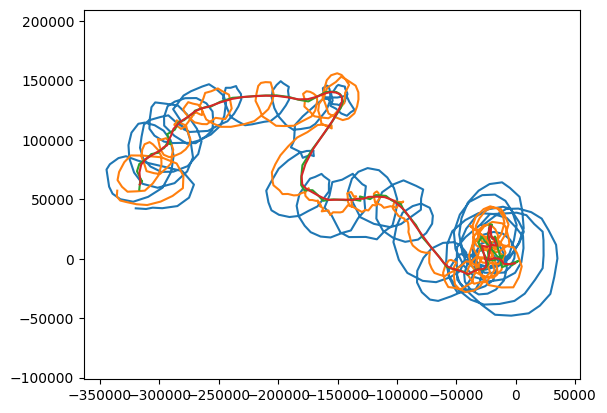

In [5]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d]
    plt.plot(df.x, df.y)

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


Text(0.5, 0, '$\\rho$ (m)')

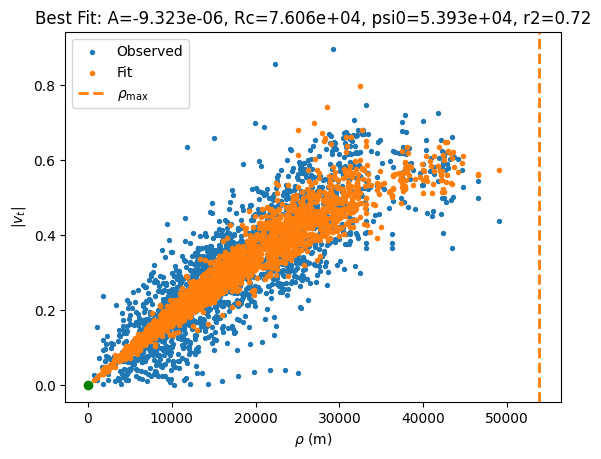

In [6]:
_, ax = plt.subplots()
Rc_opt, psi0_opt, A_opt = fit_psi_params(df_Rc_data.rho2, df_Rc_data.Qr, df_Rc_data.vt, plot=True, ax=ax)
ax.set_xlabel(r'$\rho$ (m)')


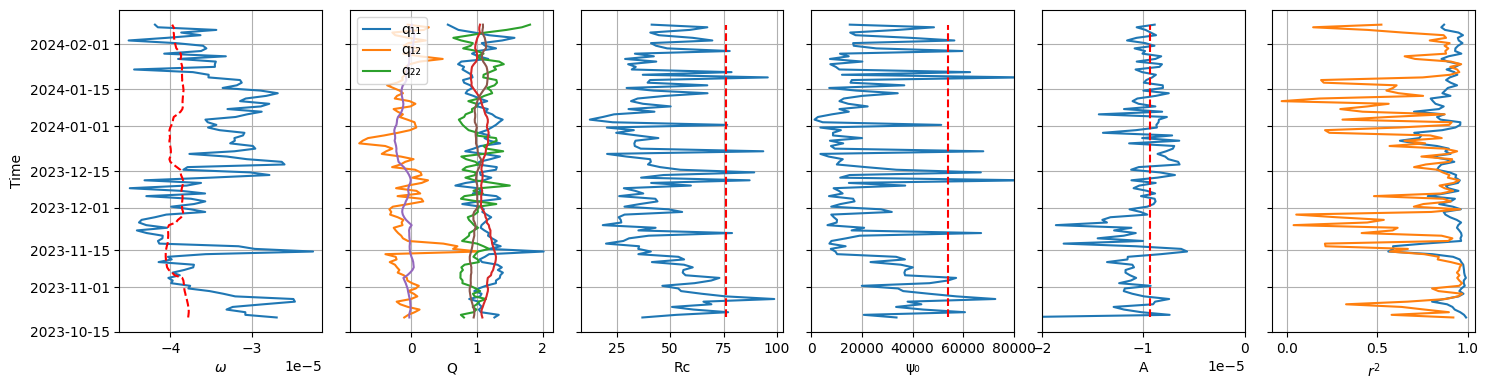

In [7]:
wdw = 20
# df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
# df_res['sRc'] = smooth(df_res.Rc, df_res.Time, window=wdw, num=len(df_res)) 
# df_res['spsi0'] = smooth(df_res.psi0, df_res.Time, window=wdw, num=len(df_res)) 
# df_res['sA'] = smooth(df_res.A, df_res.Time, window=wdw, num=len(df_res)) 

# optimised values
df_res['sw'] = 2*A_opt*(df_res.sq11 + df_res.sq22)
df_res['sRc'] = Rc_opt
df_res['spsi0'] = psi0_opt
df_res['sA'] = A_opt

fig, axs = plt.subplots(1, 6, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Time)
axs[0].plot(df_res.sw, df_res.Time, color='r', ls='--')
axs[0].set_xlabel(r'$\omega$')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1e3, df_res.Time)
axs[2].plot(df_res.sRc/1e3, df_res.Time, color='r', ls='--')
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time)
axs[3].plot(df_res.spsi0, df_res.Time, color='r', ls='--')
axs[3].set_xlim(0, 80000)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time)
axs[4].plot(df_res.sA, df_res.Time, color='r', ls='--')
axs[4].set_xlim(-2e-5, 0)
axs[4].set_xlabel('A')

axs[5].plot(df_res.r2_1, df_res.Time)
axs[5].plot(df_res.r2_2, df_res.Time)
axs[5].set_xlabel(r'$r^2$')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


In [8]:
import pickle
df_res_sat = pd.read_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_satellite_ESPRA.pkl")


Text(0.5, 1.0, '2023-11-29 12:00:00')

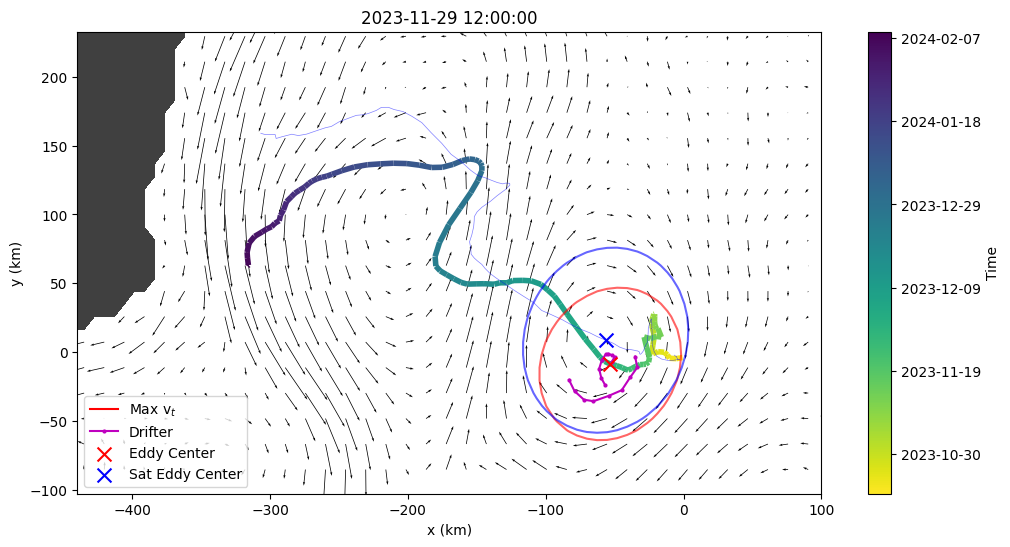

In [9]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

# x = np.linspace(-450000, 150000, 101)
# y = np.linspace(-100000, 250000, 101)
# X, Y = np.meshgrid(x, y, indexing='ij')
X, Y = x_ssh, y_ssh

k = 40
data = df_res.iloc[k]

closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
utt, vtt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
utt, vtt = np.where(mask, utt, np.nan), np.where(mask, vtt, np.nan)

fig, ax = plt.subplots(figsize=(12,6))
spac = 2
plt.quiver(x_ssh[::spac,::spac]/1e3, y_ssh[::spac,::spac]/1e3,
           utt[::spac,::spac], vtt[::spac,::spac], width=.001, scale=30)
# for dd, d in enumerate(df_drifters.ID.unique()):
#     df = df_drifters[df_drifters.ID==d]
#     plt.plot(df.x/1e3, df.y/1e3, lw=.5, alpha=.3, color='m',
#              label='Drifter Tracks'if dd==0 else'')
# plt.plot(df_res.sxc/1e3, df_res.syc/1e3) 
x,y,t=df_res.sxc/1e3,df_res.syc/1e3,df_res.Time
t_num=mdates.date2num(t)
pts=np.array([x,y]).T.reshape(-1,1,2)
segs=np.concatenate([pts[:-1],pts[1:]],1)
lc=LineCollection(segs,cmap='viridis_r',norm=plt.Normalize(t_num.min(),t_num.max()),lw=4)
lc.set_array(t_num)
ax.add_collection(lc)
cb=fig.colorbar(lc,ax=ax)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
cb.set_label('Time')

# Main Timeframe
dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2],
            colors='r', zorder=3, linewidths=1.5, alpha=.6)
plt.plot([], [], color='r', lw=1.5, label=r'Max v$_t$') 
df = dic_drif[data.Time]
for dd, d in enumerate(df.ID.unique()):
    df_d = df[df.ID==d]
    plt.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m',
             markersize=4, label='Drifter'if dd==0 else'')
plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r',
            s=100, zorder=5, label='Eddy Center')

# # Other Timeframes
# alpha = .3
# for t_idx in [51, 80, 102]:
    
#     data = df_res.iloc[t_idx]
#     dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2],
#                 colors='r', zorder=3, alpha=alpha)
#     df = dic_drif[data.Time]
#     for d in df.ID.unique():
#         df_d = df[df.ID==d]
#         plt.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m',
#                  markersize=4, alpha=alpha)
#     plt.scatter(data.xc/1e3, data.yc/1e3, marker='x', color='r', s=55, zorder=5)

# Compare with satellite ESPRA results
if closest in df_res_sat.Time.values:
    data_res_sat = df_res_sat[df_res_sat.Time==closest].iloc[0]
    
    plt.plot(df_res_sat.sxc/1e3, df_res_sat.syc/1e3, color='b', lw=.5, alpha=.5)
    dx_ell, dy_ell = X/1e3 - data_res_sat.sxc/1e3, Y/1e3 - data_res_sat.syc/1e3
    rho2_ell = data_res_sat.sq11*dx_ell**2 + 2*data_res_sat.sq12*dx_ell*dy_ell + data_res_sat.sq22*dy_ell**2
    plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data_res_sat.sRc/1e3)**2/2],
                colors='b', zorder=3, linewidths=1.5, alpha=.6)
    plt.scatter(data_res_sat.sxc/1e3, data_res_sat.syc/1e3, marker='x', color='b',
                s=100, zorder=5, label='Sat Eddy Center')

mask_nan = np.isnan(utt)
land_mask = np.where(mask_nan & mask, 0, np.nan)
plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')

plt.axis('equal'); plt.legend(loc='lower left')
plt.xlim(-440, 100); plt.ylim(-100, 230)
plt.xlabel('x (km)'); plt.ylabel('y (km)')
plt.title(data.Time)


In [10]:
for t_idx in range(len(df_res)):
        
    data = df_res.iloc[t_idx]
        
    closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
    utt, vtt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
    
    mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
    utt, vtt = np.where(mask, utt, np.nan), np.where(mask, vtt, np.nan)
    
    fig, ax = plt.subplots(figsize=(10,6))
    spac = 2
    plt.quiver(x_ssh[::spac,::spac]/1e3, y_ssh[::spac,::spac]/1e3,
               utt[::spac,::spac], vtt[::spac,::spac], width=.001, scale=30)
    
    # Drifter Data
    plt.plot(df_res.sxc/1e3, df_res.syc/1e3, color='r', lw=.5, alpha=.5)
    dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
    rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
    plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2],
                colors='r', zorder=3, linewidths=1.5, alpha=.6)
    plt.plot([], [], color='r', lw=1.5) 
    df = dic_drif[data.Time]
    for dd, d in enumerate(df.ID.unique()):
        df_d = df[df.ID==d]
        plt.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m',
                 markersize=4, label='Drifter'if dd==0 else'')
    plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r',
                s=25, zorder=5, label='Drifter Eddy Center')
    
    # Compare with satellite ESPRA results
    if closest in df_res_sat.Time.values:
        data_res_sat = df_res_sat[df_res_sat.Time==closest].iloc[0]
        
        plt.plot(df_res_sat.sxc/1e3, df_res_sat.syc/1e3, color='b', lw=.5, alpha=.5)
        dx_ell, dy_ell = X/1e3 - data_res_sat.sxc/1e3, Y/1e3 - data_res_sat.syc/1e3
        rho2_ell = data_res_sat.sq11*dx_ell**2 + 2*data_res_sat.sq12*dx_ell*dy_ell + data_res_sat.sq22*dy_ell**2
        plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data_res_sat.sRc/1e3)**2/2],
                    colors='b', zorder=3, linewidths=1.5, alpha=.6)
        plt.scatter(data_res_sat.sxc/1e3, data_res_sat.syc/1e3, marker='x', color='b',
                    s=25, zorder=5, label='Satellite Eddy Center')
    
    mask_nan = np.isnan(utt)
    land_mask = np.where(mask_nan & mask, 0, np.nan)
    plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')
    
    plt.axis('equal'); plt.legend(loc='lower left')
    plt.xlim(-440, 100); plt.ylim(-100, 230)
    plt.xlabel('x (km)'); plt.ylabel('y (km)')
    plt.title(data.Time)
    
    plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_drifter_data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
    plt.close()


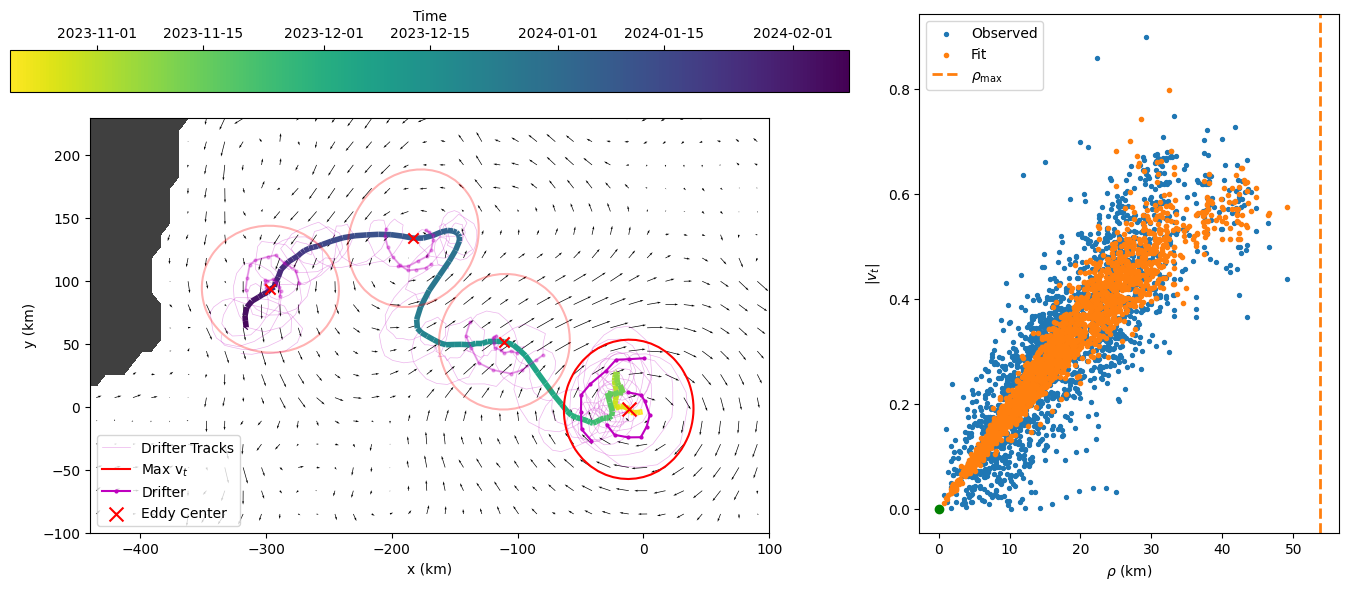

In [11]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from scipy.optimize import curve_fit

# --- Setup Grid ---
x = np.linspace(-450000, 150000, 101)
y = np.linspace(-100000, 250000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

# --- Setup Figure (1x2) ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
ax = axs[0]

# --- Plot 1: Eddy field and drifters ---
k = 4
data = df_res.iloc[k]
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
utt, vtt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3 >= -450) & (x_ssh/1e3 <= 150) & (y_ssh/1e3 >= -100) & (y_ssh/1e3 <= 250)
utt, vtt = np.where(mask, utt, np.nan), np.where(mask, vtt, np.nan)

spac = 2
ax.quiver(x_ssh[::spac,::spac]/1e3, y_ssh[::spac,::spac]/1e3,
           utt[::spac,::spac], vtt[::spac,::spac], width=.001, scale=30)
for dd, d in enumerate(df_drifters.ID.unique()):
    df = df_drifters[df_drifters.ID == d]
    ax.plot(df.x/1e3, df.y/1e3, lw=.5, alpha=.3, color='m', label='Drifter Tracks' if dd == 0 else '')

x, y, t = df_res.sxc/1e3, df_res.syc/1e3, df_res.Time
t_num = mdates.date2num(t)
pts = np.array([x, y]).T.reshape(-1, 1, 2)
segs = np.concatenate([pts[:-1], pts[1:]], 1)
lc = LineCollection(segs, cmap='viridis_r', norm=plt.Normalize(t_num.min(), t_num.max()), lw=4)
lc.set_array(t_num)
ax.add_collection(lc)

# --- Horizontal top colourbar with date formatting ---
cb = fig.colorbar(lc, ax=ax, orientation='horizontal', location='top')
cb.set_label('Time')
cb.ax.xaxis_date()
cb.ax.xaxis.set_major_locator(mdates.AutoDateLocator())
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
cb.ax.tick_params(rotation=0)

# --- Ellipse & Eddy plotting ---
dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
ax.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2], colors='r', linewidths=1.5, zorder=3)
ax.plot([], [], color='r', lw=1.5, label=r'Max v$_t$')

df = dic_drif[data.Time]
for dd, d in enumerate(df.ID.unique()):
    df_d = df[df.ID == d]
    ax.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m', markersize=4, label='Drifter' if dd == 0 else '')
ax.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=100, zorder=5, label='Eddy Center')

for t_idx in [51, 80, 102]:
    data = df_res.iloc[t_idx]
    dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
    rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
    ax.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2], colors='r', alpha=.3, zorder=3)
    df = dic_drif[data.Time]
    for d in df.ID.unique():
        df_d = df[df.ID == d]
        ax.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m', markersize=4, alpha=.3)
    ax.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=55, zorder=5)

mask_nan = np.isnan(utt)
land_mask = np.where(mask_nan & mask, 0, np.nan)
ax.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')

ax.set_aspect('equal')
ax.legend(loc='lower left')
ax.set_xlim(-440, 100)
ax.set_ylim(-100, 230)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')

# --- Plot 2: vt Fit ---
ax2 = axs[1]
fit_psi_params(df_Rc_data.rho2/1e6, df_Rc_data.Qr/1e3, df_Rc_data.vt, plot=True, ax=ax2)
ax2.set_title(''); ax2.set_xlabel(r'$\rho$ (km)')

plt.tight_layout()
plt.show()


In [12]:
df_res['Data'] = 'Drifter'
df_res['Method'] = 'ESPRA'
df_res


,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Time,...,syc,sq11,sq12,sq22,sw,sRc,spsi0,sA,Data,Method
0,-3294.288089,-5573.143564,-0.000027,"[[1.263598262431774, -0.10707401251595011], [-...",37046.440822,33631.773727,-0.000025,0.991515,0.921077,2023-10-20 12:00:00,...,-3778.545497,1.080253,-0.029246,0.948332,-0.000038,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
1,1945.672354,-1983.947431,-0.000031,"[[1.3293208187656118, -0.04500610074747553], [...",52944.843364,20735.378220,-0.000007,0.980386,0.579351,2023-10-21 12:00:00,...,-4077.222378,1.069124,-0.031059,0.957261,-0.000038,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
2,-5712.588438,-4674.576140,-0.000031,"[[1.0579383841342862, 0.051316695486210075], [...",77158.694528,60629.582976,-0.000010,0.959225,0.896563,2023-10-22 12:00:00,...,-4605.789386,1.065489,-0.022748,0.959133,-0.000038,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
3,-11550.619825,-7158.844587,-0.000033,"[[1.0271745315216445, 0.12584982563735977], [0...",60917.129158,44142.566397,-0.000012,0.928635,0.761759,2023-10-23 12:00:00,...,-4368.140371,1.070702,-0.012216,0.954116,-0.000038,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
4,-12920.830773,-1271.000387,-0.000032,"[[1.0737560400489239, -0.05122008584011388], [...",50894.230657,33467.546836,-0.000013,0.916079,0.634621,2023-10-24 12:00:00,...,-1894.671416,1.086132,-0.010597,0.941483,-0.000038,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,-316915.391322,79699.292143,-0.000036,"[[1.1809806981165483, -0.24468992799586411], [...",44744.152257,17489.727897,-0.000009,0.974400,0.867415,2024-02-04 12:00:00,...,79305.607801,1.024348,0.047091,1.097389,-0.000040,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
108,-318831.676912,73550.482818,-0.000039,"[[0.9598894244897216, -0.28785697587228576], [...",40725.024525,15360.728085,-0.000009,0.949578,0.642389,2024-02-05 12:00:00,...,72656.053628,1.043208,0.041497,1.080350,-0.000040,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
109,-314499.721779,64718.385923,-0.000034,"[[0.7170437097855845, 0.19032273336048194], [0...",59145.785284,34186.860903,-0.000010,0.874984,0.448321,2024-02-06 12:00:00,...,68379.874819,1.033408,0.007941,1.082745,-0.000039,76056.694693,53931.96441,-0.000009,Drifter,ESPRA
110,-316009.011651,66870.755715,-0.000042,"[[0.6369083577209371, 0.2663675672916547], [0....",67418.478681,48412.663540,-0.000011,0.854350,0.145338,2024-02-07 12:00:00,...,63253.337536,1.034303,-0.002401,1.090068,-0.000040,76056.694693,53931.96441,-0.000009,Drifter,ESPRA


In [13]:
df_res.to_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_drifter_ESPRA.pkl")
